In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
import seaborn as sns

In [2]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [5]:
# connect to mongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client.pokemon_db

In [3]:
combats = pd.read_csv('csv/combats.csv')

In [4]:
# get the first 40,000 rows as train data
combats_train = combats[:40000]

In [5]:
winner = combats_train.groupby('Winner').count().reset_index()
winner = winner.drop(columns=['Second_pokemon']).rename(columns={'Winner': 'pokemon_id', 'First_pokemon': 'win_battle'})

In [6]:
loser = []
for index, row in combats_train.iterrows():
    first = row[0]
    second = row[1]
    win = row[2]
    
    if(first == win):
        lose = second 
    else: 
        lose = first
    loser.append(lose)

In [7]:
combats_train['loser'] = loser

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
lost_df = combats_train.groupby('loser').count().reset_index().drop(columns=['Second_pokemon', 'First_pokemon']).rename(columns={'loser': 'pokemon_id', 'Winner': 'lose_battle'})

# get pokemon battle data df

In [9]:
full = lost_df.merge(winner, on='pokemon_id', how='outer')

In [10]:
full['battle_num'] = full.lose_battle + full.win_battle
full['win_rate'] = np.round(full.win_battle / full.battle_num * 100, decimals=2)

In [12]:
sns.set(color_codes=True)

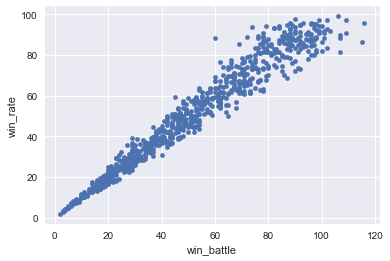

In [15]:
full.plot.scatter(x='win_battle', y='win_rate').get_figure().savefig("../static/img/linear", bbox_inches="tight")


# check linear model win_rate error

In [16]:
model = linear_model.LinearRegression()

In [17]:
# drop na in dataframe
full_check = full.dropna()

In [18]:
X = full_check.win_battle.values.reshape(-1, 1)
y = full_check.win_rate.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [20]:
MSE = mean_squared_error(y_test, prediction)
r2 = model.score(X_test, y_test)
print(f"MSE: {MSE}, R2: {r2}")

MSE: 33.47524144279318, R2: 0.9465761303812115


In [21]:
print(model.coef_, model.intercept_)
a = np.round(model.coef_, decimals=2)
b = np.round(model.intercept_, decimals=2)
print('win_rate = ' + str(a[0][0]) + 'win_bat + ' + str(b[0]))

[[0.93602631]] [2.24870324]
win_rate = 0.94win_bat + 2.25


# battle instance

In [10]:
bat_instance = []
for index, row in combats_train.iterrows():
    battle = [row[0], row[1]]
    battle.sort()
    
    battle_inst = str(battle[0]) + 'vs' + str(battle[1])
    bat_instance.append(battle_inst)

In [11]:
combats_train['bat_instance'] = bat_instance

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
bat_inst_num = combats_train.bat_instance.value_counts().to_frame().reset_index()
bat_inst_num = bat_inst_num.rename(columns={'index': 'bat_instance', 'bat_instance': 'instance_num'})

In [13]:
combats_train = combats_train.merge(bat_inst_num, on='bat_instance', how='left')

In [14]:
# battle history def
def get_win_rate(battle_time, combats_df):
    winner_out_list = []
    combat_len = len(combats_df)
    for i in range(int(combat_len / battle_time)):
        # select 'battle_time' rows every time
        start_row = i * battle_time
        df = combats_df.iloc[start_row: start_row + battle_time]
        bt_ins = df.iloc[0]['bat_instance']
        winner = df.Winner.value_counts()
        if len(winner) == 1:
            winner_out = {'bat_instance': bt_ins, 'Winner': winner.index[0], 'win_rate': 100, 'battle_time': battle_time}
            winner_out_list.append(winner_out)
        else:
            win = winner.idxmax()
            win_rate = np.round(winner.max() / battle_time * 100, decimals=2)
            winner_out_list.append({'bat_instance': bt_ins, 'Winner': win, 'win_rate': win_rate, 'battle_time': battle_time})
    
    return winner_out_list

In [15]:
combats_4 = combats_train.loc[combats_train.instance_num == 4].sort_values(by='bat_instance')
combats_4_history = get_win_rate(4, combats_4)

In [16]:
combats_3 = combats_train.loc[combats_train.instance_num == 3].sort_values(by='bat_instance')
combats_3_history = get_win_rate(3, combats_3)

In [17]:
combats_2 = combats_train.loc[combats_train.instance_num == 2].sort_values(by='bat_instance')
combats_2_history = get_win_rate(2, combats_2)

In [18]:
combats_1 = combats_train.loc[combats_train.instance_num == 1].sort_values(by='bat_instance')
combats_1_history = get_win_rate(1, combats_1)

In [19]:
combats_4_history.extend(combats_3_history)
combats_4_history.extend(combats_2_history)
combats_4_history.extend(combats_1_history)

In [20]:
combats_history_df = pd.DataFrame(combats_4_history)

# predict model

In [207]:
# get combat history data from mongoDB
col_combat = db['combat_history']
combats_history_df = pd.DataFrame(list(col_combat.find())).drop(columns=['_id'])

In [208]:
# get pokemon battle data from mongoDB
col_full = db['pokemon_battle']
full = pd.DataFrame(list(col_full.find())).drop(columns=['_id', 'Unnamed: 0'])

In [209]:
# get win_rate check chart based on battle numbers in history
win_rate = combats_history_df.groupby('battle_time').win_rate.value_counts().to_frame().rename(columns={'win_rate': 'win_num'})
win_per = [
    100, 
    win_rate.loc[(2, 100)].win_num / (win_rate.loc[(2, 100)].win_num + win_rate.loc[(2, 50)].win_num) * 100,
    win_rate.loc[(2, 50)].win_num / (win_rate.loc[(2, 100)].win_num + win_rate.loc[(2, 50)].win_num) * 100,
    win_rate.loc[(3, 100)].win_num / (win_rate.loc[(3, 100)].win_num + win_rate.loc[(3, 66.67)].win_num) * 100,
    win_rate.loc[(3, 66.67)].win_num / (win_rate.loc[(3, 100)].win_num + win_rate.loc[(3, 66.67)].win_num) * 100,
    win_rate.loc[(4, 100)].win_num / (win_rate.loc[(4, 100)].win_num + win_rate.loc[(4, 75)].win_num) * 100,
    win_rate.loc[(4, 75)].win_num / (win_rate.loc[(4, 100)].win_num + win_rate.loc[(4, 75)].win_num) * 100,
]
win_rate['per'] = np.round(win_per, decimals=2)

In [210]:
win_rate

win_num     per
battle_time win_rate                 
1           100.00      35156  100.00
2           100.00       2196   96.78
            50.00          73    3.22
3           100.00         91   92.86
            66.67           7    7.14
4           100.00          2   66.67
            75.00           1   33.33

In [211]:
win_rate_check = win_rate

In [171]:
# data sample (has no battle history in record)
pok_t_1 = full.iloc[1]['pokemon_id']
pok_t_2 = full.iloc[2]['pokemon_id']

In [172]:
# check win rate if battle has history
enough_history = 50
# win rate general depends on Linear Regression Model R2 score
win_rate_with_linear = 0.94
# mean error 
error_rate_mean = 4.07

In [173]:
# battle history check list
bat_history = combats_history_df.bat_instance.tolist()

In [174]:
# generate battle instance
def get_battle_instance(pok_1, pok_2):
    pok_container = [np.int(pok_1), np.int(pok_2)]
    pok_container.sort()
    battle = str(pok_container[0]) + 'vs' + str(pok_container[1])
    
    return battle

In [245]:
# check battle num if battle does not have related records in hostory or record result are even
# win battle check is based on win_battle VS win_rate linear model
predict_win_rate = lambda x: x * 0.93 + 2.35
def check_win_battle(pok_id_1, pok_id_2):
    # select out pokemon series
    pok_s_1 = full.loc[full.pokemon_id == pok_id_1].T.squeeze()
    pok_s_2 = full.loc[full.pokemon_id == pok_id_2].T.squeeze()
    # check if this is a low possibility win predict
    win_rate_dif = np.abs(pok_s_1.win_rate - pok_s_2.win_rate)
    #win_bat_dif = pok_s_1.win_battle - pok_s_2.win_battle
    if win_rate_dif < error_rate_mean:
        exp_rate_1 = predict_win_rate(pok_s_1.win_battle)
        exp_rate_2 = predict_win_rate(pok_s_2.win_battle)
        exp_dif = np.abs(exp_rate_1 - exp_rate_2)
        rate_dif = np.abs(exp_dif - win_rate_dif)
        if exp_dif >= win_rate_dif:
            win_rate_predict = np.round(win_rate_with_linear * (win_rate_dif - rate_dif) / 100, decimals=2)
        else:
            win_rate_predict = np.round(win_rate_with_linear * (win_rate_dif + rate_dif) / 100, decimals=2)
    else:
        win_rate_predict = win_rate_with_linear
    
    if pok_s_1.win_rate > pok_s_2.win_rate:
        win_pre = pok_s_1.pokemon_id
    else:
        win_pre = pok_s_2.pokemon_id
    
    return {'win_predict': win_pre, 'win_rate': win_rate_predict, 'history': False}

In [246]:
def predict_winner(pok_id_1, pok_id_2):
    pok_1 = np.int(pok_id_1)
    pok_2 = np.int(pok_id_2)
    # set up battle instance
    battle = get_battle_instance(pok_1, pok_2)
    
    # check if this battle has history 
    if battle in combats_history_df.bat_instance.tolist():
        # select the record out
        record = combats_history_df.loc[combats_history_df.bat_instance == battle].T.squeeze()
        
        # check if win_rate > 50%
        if record['win_rate'] > 50:
            # check if this win_rate has enough records as reference
            bat_time = record['battle_time']
            bat_num_check = bat_time + 1
            bat_sum = win_rate_check.loc[(bat_num_check)].win_num.sum()
            
            # check if bat_num data sample big enough
            if bat_sum > enough_history:
                # select valid data out (win_rate > 50)
                valid_d = win_rate_check.loc[(bat_num_check)].loc[win_rate_check.loc[(bat_num_check)].index > 50]
                win_rate = 0
                for index, row in valid_d.iterrows():
                    row_rate = np.round(index * row['per'] / 100, decimals=2)
                    win_rate = win_rate + row_rate
                win_pre = record['Winner']
                win_out = {'win_predict': win_pre, 'win_rate': win_rate, 'history': True}
                
            else:
                win_out = check_win_battle(pok_1, pok_2)
            
        else:
            win_out = check_win_battle(pok_1, pok_2)

    else:
        win_out = check_win_battle(pok_1, pok_2)
        
    return win_out

In [247]:
predict_winner(pok_t_1, pok_t_2)

{'history': False, 'win_predict': 3.0, 'win_rate': 0.94}

# test prediction 

In [249]:
# choose 10000 sample
combats_test = combats[40000:]

In [250]:
def test_prediction(test_df):
    win_out_list = []
    for index, row in test_df.iterrows():
        pok_1 = row['First_pokemon']
        pok_2 = row['Second_pokemon']
        win_pre = predict_winner(pok_1, pok_2)
        win_out_list.append(win_pre)
    
    return win_out_list

In [251]:
win_out_list = []
for index, row in combats_test.iterrows():
    pok_1 = row['First_pokemon']
    pok_2 = row['Second_pokemon']
    win_pre = predict_winner(pok_1, pok_2)
    win_out_list.append(win_pre)

In [252]:
combats_out = combats_test.reset_index().join(pd.DataFrame(win_out_list))
error_list = combats_out.loc[combats_out.Winner != combats_out.win_predict].reset_index().drop(columns=['index'])

In [272]:
predict_err_rate = pd.DataFrame(
    data ={
        'err': error_list.groupby('history').history.count(),
        'total': combats_out.groupby('history').history.count(),
    }
)

In [275]:
# pokemon has battle history has much lower error rate in prediction 
# battle prediction accuracy could increase with gaining battle instance data
predict_err_rate['rate'] = np.round(predict_err_rate.err / predict_err_rate.total * 100, decimals=2)
predict_err_rate

,err,total,rate
history,,,
False,1091,8826,12.36
True,27,1174,2.30


# check error list and solution to modify model

In [239]:
# check error list
error_num_list = []
errot_rate_list = []
has_history_list = []
for index, row in error_list.iterrows():
    #error record are not caused by historical data
    battle = get_battle_instance(row['First_pokemon'], row['Second_pokemon'])
   
    pok_1 = full.loc[full.pokemon_id == row['First_pokemon']]
    pok_2 = full.loc[full.pokemon_id == row['Second_pokemon']]
    pok_1 = pok_1.append(pok_2)
    #dif_bat_num = np.absolute(pok_1.iloc[0]['battle_num'] - pok_1.iloc[1]['battle_num'])
    dif_win_num = np.absolute(pok_1.iloc[0]['win_battle'] - pok_1.iloc[1]['win_battle'])
    dif_win_rate = np.absolute(pok_1.iloc[0]['win_rate'] - pok_1.iloc[1]['win_rate'])
    error_num_list.append(dif_win_num)
    errot_rate_list.append(dif_win_rate)

In [234]:
# error number mean
error_num = pd.Series(error_num_list).dropna()
error_num_mean = np.round(error_num.mean(), decimals=2)

In [237]:
# error rate mean 
errot_rate = pd.Series(errot_rate_list).dropna()
error_rate_mean = np.round(errot_rate.mean(), decimals=2)
# will update these 2 parametres in def check_win_battle to improve win rate accuracy
print(error_num_mean, error_rate_mean)

17.28 15.37
